In [1]:
import sys
sys.path.append("/tf/easl-eye")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

## Local Package
import easl_eye as eye
from easl_eye.io import *
from easl_eye.preprocess import eyes as blink
from easl_eye.viz import raw_gaze_plot, session_video

In [3]:
# Loading the two different datasets
image_tracking = get_viewer_tracking_info(url="http://amc-tensor1.ucdenver.pvt/eyetracking")
eye_tracking = load_eyetracking_data(fname="/tf/eye-tracking/test_gaze_data.csv")

In [4]:
eye_tracking = blink.format_data(eye_tracking, 
                                 screen_size=(59.789,33.631), # cm
                                 screen_res=(2560,1440), # px
                                 viewing_dist=82) # cm

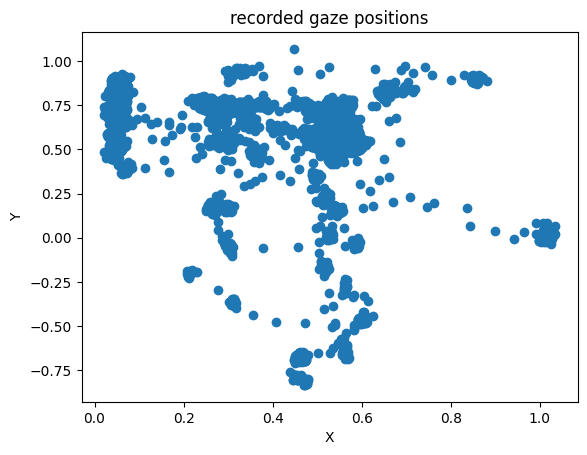

In [5]:
raw_gaze_plot(eye_tracking)

In [6]:
aligned_data = eye.align_tracking_data(image_tracking=image_tracking, eye_tracking=eye_tracking)

/tf/easl-eye/easl_eye/integrate.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_tracking['ui_timestamp_us'] = image_tracking['ui_timestamp'].apply(convert2us)
/tf/easl-eye/easl_eye/integrate.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_tracking['adjusted_timestamp'] = image_tracking['ui_timestamp_us'].apply(
/tf/easl-eye/easl_eye/integrate.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [7]:
aligned_data = blink.classify(aligned_data , 'right', [0.3026622037, 0.82349537])
aligned_data = blink.classify(aligned_data , 'left', [0.3026622037, 0.82349537])

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
instance_map = eye.build_instance_map()

In [9]:
session_video(
    aligned_data, 
    instance_map, 
    dims=(900, 900), 
    return_array=False, 
    overlay_eyetracking=True
)

error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:658: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'
